# Импорт библиотек

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import scipy.io
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision.utils import save_image

# Загрузка данных

In [4]:
# Переведем данные в привычный нам NumPy формат
mat_data = scipy.io.loadmat('./frey_rawface.mat')
data = mat_data['ff'].T.reshape(-1, 1, 28, 20)
data = data.astype('float32') / 255.0
print(f"Number of instances: {len(data)}")

Number of instances: 1965


In [5]:
# Подготовка torch датасета
class FreyDataset(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return (len(self.X))
    def __getitem__(self, index):
        data = self.X[index]
        return torch.tensor(data, dtype=torch.float)

## Задание 1. Разделите данные на `train` и `val` части. К `val` отнесите последние 300 объектов. Подготовьте данные для обучения с помощью `FreyDataset` и `DataLoader`.

In [9]:
x_train = FreyDataset(data[:1500])
x_val = FreyDataset(data[1500:])
print(f"Training instances: {len(x_train)}")
print(f"Validation instances: {len(x_val)}")

Training instances: 1500
Validation instances: 465


In [10]:
batch_size = 64

train_loader = DataLoader(x_train)
val_loader = DataLoader(x_val)

In [11]:
kernel_size = 4
stride = 1
padding = 0
init_kernel = 16 

# Вариационныей автоэнкодер

## Задание 2. Допишите трюк репараметризации в функции `reparameterize`. 

*Подробнее о трюке можно узнать в [дополнительных материалах](https://drive.google.com/file/d/18LWM4jROW6A89B7XEpH6w66M5BomGUKn/view?usp=sharing).*

In [12]:
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # энкодер
        self.enc1 = nn.Conv2d(
            in_channels=1, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_kernel, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_kernel*2, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_kernel*4, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc5 = nn.Conv2d(
            in_channels=init_kernel*8, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        # декодер 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_kernel*8, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_kernel*4, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_kernel*2, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec5 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=1, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
 
    def forward(self, x):
        # кодирование
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = self.enc5(x)
        # сэмплирование среднего и logvar
        mu = x
        log_var = x
        # получаем латентное предстваление через репораметризацию
        z = self.reparameterize(mu, log_var)
 
        # декодирование
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        reconstruction = torch.sigmoid(self.dec5(x))
        return reconstruction, mu, log_var

In [13]:
lr = 0.001
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

## Задание 3. Прежде, чем перейти к обучению модели, определите функцию потерь VAE.

In [15]:
def final_loss(bce_loss, mu, logvar):
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    total_loss = bce_loss + kl_loss
    
    return total_loss

## Обучение модели

In [19]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(x_train)/dataloader.batch_size)):
        data = data
        data = data.to(device)
        data = data
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [20]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(x_val)/dataloader.batch_size)):
            data= data
            data = data.to(device)
            data = data
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(x_val)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data[:8], reconstruction[:8]))
                save_image(both.cpu(), f"./output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [21]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 20


100%|██████████| 465/465 [00:00<00:00, 471.58it/s]


Train Loss: 350.5195
Val Loss: 359.4132
Epoch 2 of 20


100%|██████████| 465/465 [00:00<00:00, 509.91it/s]


Train Loss: 349.3204
Val Loss: 357.8627
Epoch 3 of 20


100%|██████████| 465/465 [00:00<00:00, 521.00it/s]


Train Loss: 349.2169
Val Loss: 358.4506
Epoch 4 of 20


100%|██████████| 465/465 [00:00<00:00, 482.14it/s]


Train Loss: 349.1735
Val Loss: 358.4936
Epoch 5 of 20


100%|██████████| 465/465 [00:00<00:00, 474.45it/s]


Train Loss: 349.1092
Val Loss: 357.8372
Epoch 6 of 20


100%|██████████| 465/465 [00:00<00:00, 516.94it/s]


Train Loss: 349.0835
Val Loss: 359.0703
Epoch 7 of 20


100%|██████████| 465/465 [00:00<00:00, 497.49it/s]


Train Loss: 349.1926
Val Loss: 358.4469
Epoch 8 of 20


100%|██████████| 465/465 [00:00<00:00, 510.67it/s]


Train Loss: 349.0931
Val Loss: 359.3743
Epoch 9 of 20


100%|██████████| 465/465 [00:01<00:00, 396.21it/s]


Train Loss: 349.0644
Val Loss: 358.9108
Epoch 10 of 20


100%|██████████| 465/465 [00:00<00:00, 493.11it/s]


Train Loss: 349.4151
Val Loss: 357.2295
Epoch 11 of 20


100%|██████████| 465/465 [00:00<00:00, 480.75it/s]


Train Loss: 349.2980
Val Loss: 356.7569
Epoch 12 of 20


100%|██████████| 465/465 [00:00<00:00, 518.79it/s]


Train Loss: 349.3507
Val Loss: 356.8867
Epoch 13 of 20


100%|██████████| 465/465 [00:00<00:00, 502.18it/s]


Train Loss: 349.3398
Val Loss: 356.6053
Epoch 14 of 20


100%|██████████| 465/465 [00:01<00:00, 425.53it/s]


Train Loss: 349.2977
Val Loss: 356.2008
Epoch 15 of 20


100%|██████████| 465/465 [00:00<00:00, 504.22it/s]


Train Loss: 349.3209
Val Loss: 356.3856
Epoch 16 of 20


100%|██████████| 465/465 [00:00<00:00, 516.36it/s]


Train Loss: 349.3678
Val Loss: 356.4615
Epoch 17 of 20


100%|██████████| 465/465 [00:00<00:00, 514.14it/s]


Train Loss: 349.4285
Val Loss: 356.3751
Epoch 18 of 20


100%|██████████| 465/465 [00:00<00:00, 515.20it/s]


Train Loss: 349.4413
Val Loss: 356.5963
Epoch 19 of 20


100%|██████████| 465/465 [00:00<00:00, 515.81it/s]


Train Loss: 349.4678
Val Loss: 357.5825
Epoch 20 of 20


100%|██████████| 465/465 [00:00<00:00, 518.99it/s]

Train Loss: 349.7118
Val Loss: 356.4847


## Визуализация полученных изображений

In [22]:
from PIL import Image
import matplotlib.pyplot as plt

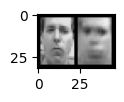

In [29]:
# 1я эпоха
image_0 = Image.open("output0.png")
plt.figure(figsize=(1, 1))
plt.imshow(image_0)

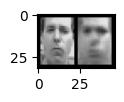

In [27]:
# 10я эпоха
image_10 = Image.open("output10.png")
plt.figure(figsize=(1, 1))
plt.imshow(image_10)

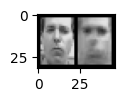

In [28]:
# 19я эпоха
image_19 = Image.open("output19.png")
plt.figure(figsize=(1, 1))
plt.imshow(image_19)